<a href="https://colab.research.google.com/github/reeda23/Deep-Learning-With-Pytorch/blob/main/14_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Transfer Learning



Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls

drive  sample_data


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning_With_Pytorch/data"
os.environ['KAGGLE_USERNAME'] = "reedasaeed" # username from the json file
os.environ['KAGGLE_KEY'] = "43209f85217ace206e0a706ff21c6f95" # key from the json file

In [4]:
%cd "/content/drive/MyDrive/Colab Notebooks/Deep_Learning_With_Pytorch/data"

/content/drive/MyDrive/Colab Notebooks/Deep_Learning_With_Pytorch/data


In [5]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Deep_Learning_With_Pytorch/data


In [ ]:
!kaggle datasets download -d ajayrana/hymenoptera-data

 86% 78.0M/90.2M [00:00<00:00, 214MB/s]
100% 90.2M/90.2M [00:00<00:00, 186MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Deep_Learning_With_Pytorch/data/hymenoptera-data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/Deep_Learning_With_Pytorch/data')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os 
import copy

In [7]:
mean = np.array([0.5,0.5,0.5])
std = np.array([0.25,0.25,0.25])

# Data Transformations

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
}

# Data Loader

In [9]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep_Learning_With_Pytorch/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=0)
                    for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Device Configuration

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
print(class_names)

['ants', 'bees']


# Imshow for tensors

In [12]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

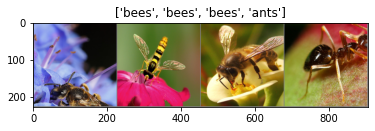

In [13]:
#Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)

        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #Set model to training mode
            else:
                model.eval() #Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #backward + optimize only if in training phase 
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    #statistics
                    running_loss +=loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
        time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return 



# Model

In [17]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names).

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr = 0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()


step_lr_schedular = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
model = train_model(model, criterion, optimizer, step_lr_schedular, num_epochs = 25)



Epoch 0/24
----------
train Loss: 3.6539 Acc: 0.4262
val Loss: 1.5009 Acc: 0.6536

Epoch 1/24
----------
train Loss: 0.7162 Acc: 0.7951
val Loss: 0.7573 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.6374 Acc: 0.7746
val Loss: 0.5524 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.5566 Acc: 0.7705
val Loss: 0.4156 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.5013 Acc: 0.7910
val Loss: 0.3949 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.3587 Acc: 0.8361
val Loss: 0.3499 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4468 Acc: 0.8279
val Loss: 0.3081 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.2815 Acc: 0.8770
val Loss: 0.3273 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3575 Acc: 0.8238
val Loss: 0.3038 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3416 Acc: 0.8566
val Loss: 0.3162 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3658 Acc: 0.8484
val Loss: 0.3224 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2907 Acc: 0.8852
val Loss: 0.3252 Acc: 0.8954

Ep

# ConvNet as fixed feature extractor

In [19]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

#Parameters of newly constructed modules have requires_grad = True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opossed to before.

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)

#Decay LR by factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5618 Acc: 0.7090
val Loss: 0.2553 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4758 Acc: 0.7787
val Loss: 0.3007 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4709 Acc: 0.8115
val Loss: 0.2416 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5156 Acc: 0.7869
val Loss: 0.1837 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4763 Acc: 0.7910
val Loss: 0.3842 Acc: 0.8170

Epoch 5/24
----------
train Loss: 0.5079 Acc: 0.7992
val Loss: 0.4434 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.5211 Acc: 0.7869
val Loss: 0.3024 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3727 Acc: 0.8197
val Loss: 0.1769 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3624 Acc: 0.8402
val Loss: 0.2132 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3722 Acc: 0.8361
val Loss: 0.1894 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3023 Acc: 0.8648
val Loss: 0.2056 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3215 Acc: 0.8689
val Loss: 0.1970 Acc: 0.9542

Ep